In [25]:
from sklearn.datasets import fetch_mldata
import pickle

### download and save data in ~/scikit_learn_data/mldata

In [26]:
mnist = fetch_mldata('MNIST original')

In [27]:
X,y=mnist["data"],mnist["target"]

In [28]:
X.shape

(70000, 784)

In [29]:
y.shape

(70000,)

### Plot and see a random image

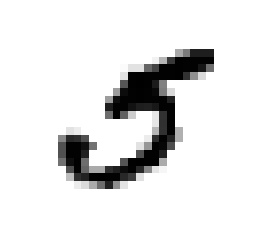

In [30]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit=X[36000]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [31]:
print(some_digit)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  86 131 225
 225 225   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  13  73 197 253 252 252 252 252   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   4  29  29 154 187 252 252 253
 252 252 233 145   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  29 252 253 252 252 252 252 253 204 112  3

In [32]:
y[36000]

5.0

In [33]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Shuffle the data set

In [34]:
import numpy as np
shuffle_index=np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index], y_train[shuffle_index]

### Creating a 5 cliassifier which tells if a number is 5 or not

In [35]:
y_train_5 = ( y_train == 5 )
y_test_5 = (y_test == 5)

In [36]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [37]:
sgd_clf.predict([some_digit])

array([False])

### Inbuild and good v/s bad classifier validation
probablity of 5 is 10%, so if classifier always says No, it is correct 90% of time

##### Good

In [38]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.93675, 0.96905, 0.92335])

##### Bad

In [39]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.9129 , 0.90965, 0.9064 ])

##### Good Similar to cross_val_score

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3,random_state=42)
for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_folds=X_train[test_index]
    y_test_folds=y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred=clone_clf.predict(X_test_folds)
    n_corrext=sum(y_pred == y_test_folds)
    print(n_corrext/len(y_pred))

0.93675
0.96905
0.92335


### Confusion Matrix
check how much the model is confused

In [41]:
#cross val predictions for each fold
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_5,cv=3)

In [42]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[51903,  2676],
       [  741,  4680]])

Above numbers are:
```
True Negatives  | False Postitives
----------------------------------
False Negatives | True Postitives
```

### Precision v/s recall

* Precision: TP/(TP+FP)
like what percent of things it says positive are actually positive
`or how correct it is`
or a metrix related to `how many negatives are shown as positives`
* Recall: TP/(TP+FN)
like what percent of things are included in positive result out of all positives
`or how many 5s it detects`
or a metrix related to `how many positives are shown as negatives`

In [43]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.636215334420881

In [44]:
recall_score(y_train_5,y_train_pred)

0.8633093525179856

##### harmonic Mean - f1 score
* Gives more stress on the smaller values
* Only gets high if both values are high
F1=2/((1/precision)+(1/recall))
= 2*(precision x recall)/(precision + recall)
= TP / (TP + (FN+FP)/2)

##### F1 = 
\begin{equation*}
\frac{2}{(\frac{1}{precision}+\frac{1}{recall})} 
\end{equation*}
OR
\begin{equation*}
2\times\frac{precision \times recall}{precision + recall}
\end{equation*}
OR
\begin{equation*}
\frac{TP} {TP + \frac{FN+FP}{2}}
\end{equation*}

In [45]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325663301244424

[-448.72838747]
[False]


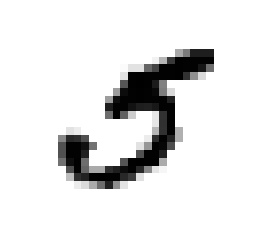

[False]


In [51]:
y_scores=sgd_clf.decision_function([some_digit])
print(y_scores)
threshold=0
y_some_digit_pred=(y_scores>threshold)
print(y_some_digit_pred)
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()
print(sgd_clf.predict([some_digit]))

#### Calculate Y Scores

In [52]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

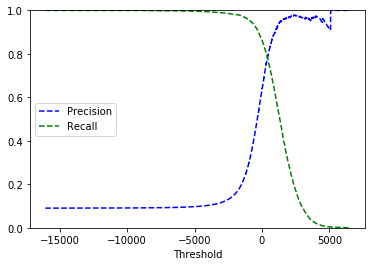

In [73]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    plt.show()
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

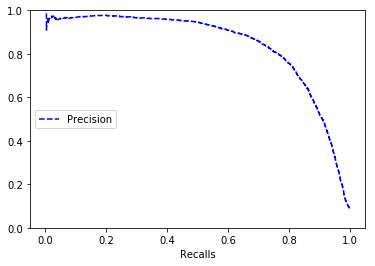

In [61]:
def plot_precision_vs_recall(precisions,recalls,thresholds):
    plt.plot(recalls,precisions,"b--",label="Precision")
    plt.xlabel("Recalls")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    plt.show()
plot_precision_vs_recall(precisions,recalls,thresholds)

In [80]:
y_train_pred_90=y_scores>1000
print(precision_score(y_train_5,y_train_pred_90))
print(recall_score(y_train_5,y_train_pred_90))

0.9059569773855488
0.6059767570558937


### ROC Curve
True Positive v/s False Positive curve